In [1]:
#%%
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Ruta del archivo (suponiendo que has subido el archivo a Google Colab)
file_path = '/content/Inflacion.xlsx'

# Leer el archivo Excel
data = pd.read_excel(file_path)

In [4]:

data = pd.read_excel(file_path, sheet_name='data', )
data = data[['Inflation']].dropna()

In [5]:
# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [6]:

# Dividir los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [7]:
# Definir el paso de tiempo (time_step)
time_step = 12


In [8]:
# Crear los conjuntos de datos de entrenamiento y prueba
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# Redimensionar la entrada a [muestras, pasos de tiempo, características]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:

#%%

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [11]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=1, epochs=1)

191/191 [==============================] - 6s 13ms/step - loss: 0.0039


In [14]:
# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [15]:
# Desescalar las predicciones
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [16]:

# Desescalar los datos originales
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [17]:
#%%

import matplotlib.pyplot as plt

# Calcular el error de la raíz cuadrada media (RMSE)
rmse_train = np.sqrt(np.mean((train_predict - y_train[0]) ** 2))
rmse_test = np.sqrt(np.mean((test_predict - y_test[0]) ** 2))

print(f'RMSE del conjunto de entrenamiento: {rmse_train}')
print(f'RMSE del conjunto de prueba: {rmse_test}')

RMSE del conjunto de entrenamiento: 19.84193503193067
RMSE del conjunto de prueba: 15.740971401628176


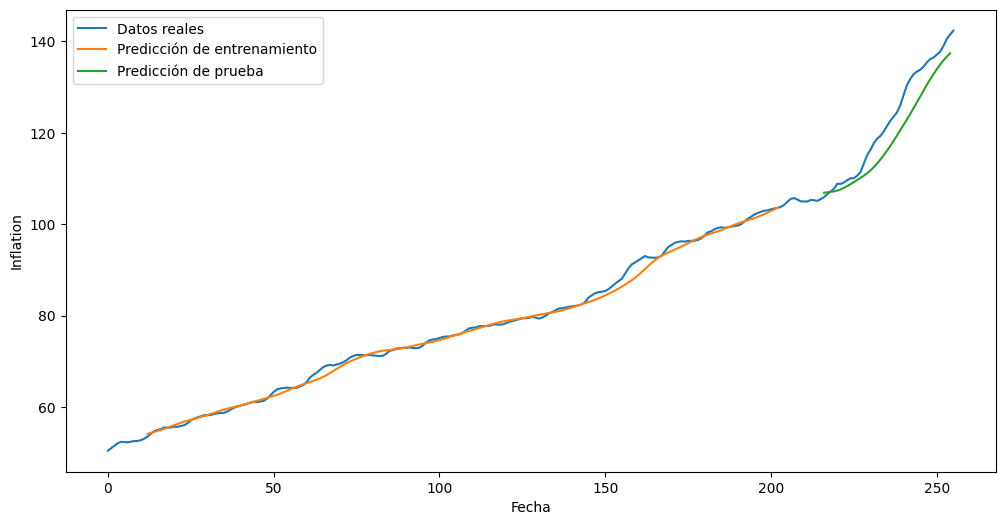

In [18]:

# Graficar los resultados
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Datos reales')
plt.plot(train_plot, label='Predicción de entrenamiento')
plt.plot(test_plot, label='Predicción de prueba')
plt.xlabel('Fecha')
plt.ylabel('Inflation')
plt.legend()
plt.show()


In [19]:

# Obtener los últimos 12 meses de datos para hacer la predicción
last_12_months = scaled_data[-time_step:]

# Crear una lista para almacenar las predicciones futuras
future_predictions = []

In [20]:

# Hacer predicciones para los próximos 12 meses
for i in range(12):
    # Redimensionar los datos de entrada
    last_12_months_reshaped = last_12_months.reshape((1, time_step, 1))
    # Hacer la predicción
    next_prediction = model.predict(last_12_months_reshaped)
    # Almacenar la predicción
    future_predictions.append(next_prediction[0, 0])
    # Actualizar los datos de entrada para la próxima predicción
    last_12_months = np.append(last_12_months[1:], next_prediction, axis=0)

1/1 [==============================] - 0s 22ms/step


In [21]:


# Desescalar las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas para las predicciones futuras
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=12, freq='M')

# Crear un DataFrame para almacenar las predicciones futuras
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Inflation_pred'])

# Mostrar las predicciones futuras
print(future_df)

                               Inflation_pred
1970-01-31 00:00:00.000000255      138.886108
1970-02-28 00:00:00.000000255      139.534744
1970-03-31 00:00:00.000000255      140.097488
1970-04-30 00:00:00.000000255      140.580383
1970-05-31 00:00:00.000000255      140.986160
1970-06-30 00:00:00.000000255      141.342346
1970-07-31 00:00:00.000000255      141.679886
1970-08-31 00:00:00.000000255      141.987366
1970-09-30 00:00:00.000000255      142.270462
1970-10-31 00:00:00.000000255      142.497818
1970-11-30 00:00:00.000000255      142.661285
1970-12-31 00:00:00.000000255      142.794342


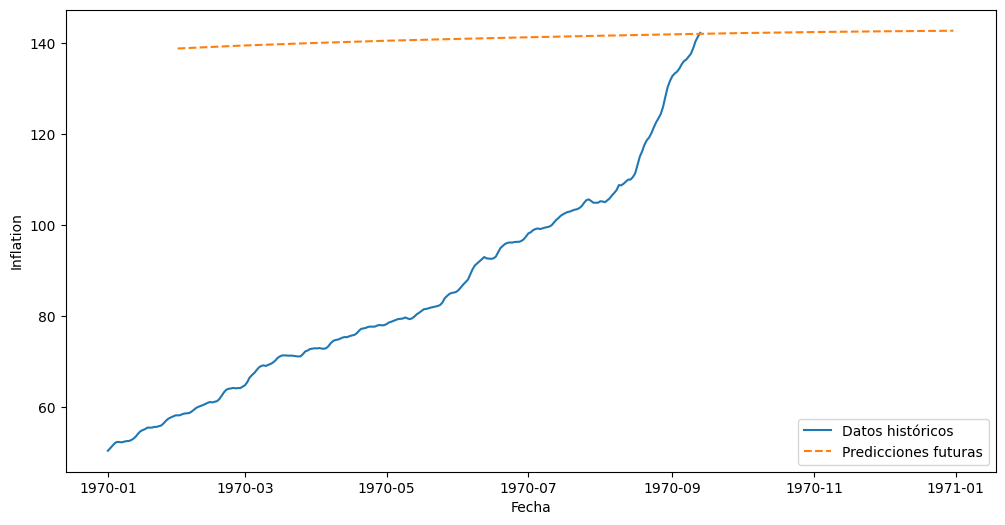

In [22]:



# Graficar las predicciones futuras junto con los datos históricos
plt.figure(figsize=(12, 6))
plt.plot(data['Inflation'], label='Datos históricos')
plt.plot(future_df, label='Predicciones futuras', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Inflation')
plt.legend()
plt.show()


# %%